# Modeling baseline

### Import data

In [1]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read data that was exported from previous session
df = pd.read_csv("../processed/cleaned_loan_data.csv")
df.head()

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti
0,4000.0,13.08,134.93,1,10.0,MORTGAGE,48000.0,Source Verified,Current,home_improvement,20.25
1,24000.0,9.16,500.07,1,6.0,RENT,57000.0,Source Verified,Current,credit_card,25.33
2,5000.0,10.49,162.49,1,10.0,MORTGAGE,55000.0,Not Verified,Fully Paid,credit_card,7.22
3,24000.0,11.05,522.42,1,10.0,MORTGAGE,43500.0,Not Verified,Current,debt_consolidation,24.55
4,14000.0,13.59,322.79,2,10.0,MORTGAGE,48000.0,Source Verified,Fully Paid,debt_consolidation,24.30


In [2]:
df.loan_status.value_counts()

loan_status
Fully Paid                                             51189
Current                                                35294
Charged Off                                            12384
Late (31-120 days)                                       535
In Grace Period                                          329
Late (16-30 days)                                         90
Does not meet the credit policy. Status:Fully Paid        69
Issued                                                    63
Does not meet the credit policy. Status:Charged Off       33
Default                                                   14
Name: count, dtype: int64

### Data preprocessing and Feature selection 

In [3]:
# Step 1 Fill missing values with median for all numerical features (For simplicity purposes)

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Apply median imputation only to numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Apply median imputation only to numeric columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


In [4]:
# Step 2 We will use Recursive Feature Elimination (RFE) with Logistic Regression to identify the most relevant features for predicting loan defaults.

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#Broader Definition of the default
default_statuses = ['Charged Off', 'Default', 'Late (31-120 days)']
df['loan_default'] = df['loan_status'].isin(default_statuses).astype(int)

# Save the cleaned and prepared dataset,this version will be reused for building enhanced models.
df.to_csv("../processed/loan_data_baseline_ready.csv", index=False)

# Ensure 'loan_default' is removed from feature selection
X_clean = df[numeric_cols].drop(columns=["loan_default"], errors="ignore")
y = df["loan_default"]

# Check dataset before scaling
print(f"Original X_clean shape: {X_clean.shape}")  # Debugging

# Standardize numeric features
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_clean)  # Returns NumPy array

# Convert back to DataFrame with correct column names
X_scaled = pd.DataFrame(X_scaled_array, columns=X_clean.columns)

# Initialize logistic regression model
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000, solver="lbfgs", n_jobs=-1)

# Run RFE on DataFrame (not NumPy array)
rfe = RFE(log_reg, n_features_to_select=10, step=5)
rfe.fit(X_scaled, y)

# Now correctly select features
selected_features_rfe = X_scaled.columns[rfe.support_]
print("Selected Features via RFE:", selected_features_rfe)

Original X_clean shape: (100000, 7)


C:\Users\Sergey\PycharmProjects\anti-fraud-app-project\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


Selected Features via RFE: Index(['loan_amnt', 'int_rate', 'installment', 'grade', 'emp_length',
       'annual_inc', 'dti'],
      dtype='object')


### Data splitting

In [5]:
from sklearn.model_selection import train_test_split

#Step 3 Model Development
X_selected = X_clean[selected_features_rfe]  # Keep only selected features
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_selected)  # Scale only selected features
X_scaled = pd.DataFrame(X_scaled_array, columns=selected_features_rfe)  # Convert back to DataFrame

# Split data into 80% training and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Print data shapes
print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)


Training Data Shape: (80000, 7)
Test Data Shape: (20000, 7)


### Baseline Model selection and training

The Logistic Regression is chosen for the loan default prediction baseline model because it's a well-established, interpretable model that works effectively for binary classification tasks. It allows us to estimate the probability of default in a clear way, which is important in financial applications where explainability and trust are essential. Additionally, it performs reliably on structured tabular data like loan information, especially when combined with techniques like class balancing and SMOTE to handle data imbalance.



In [6]:
from imblearn.over_sampling import SMOTE
# Initialize Logistic Regression Model
model_1 = LogisticRegression(class_weight="balanced", max_iter=1000, solver="lbfgs", C=0.1)

# Train Logistic Regression with class balancing
model_1 = LogisticRegression(class_weight="balanced", max_iter=1000, solver="lbfgs", C=0.1)

# Apply SMOTE to training data ( to balance the dataset )
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Retrain the model on balanced data
model_1.fit(X_train_resampled, y_train_resampled)

# Print model coefficients
print("Model_1 Training Complete.")
print("Intercept:", model_1.intercept_)
print("Coefficients:", dict(zip(selected_features_rfe, model_1.coef_[0])))

Model_1 Training Complete.
Intercept: [-0.18948197]
Coefficients: {'loan_amnt': np.float64(-0.10479601388709768), 'int_rate': np.float64(-0.5203507255695724), 'installment': np.float64(0.18734514771700145), 'grade': np.float64(1.1517334137726596), 'emp_length': np.float64(-0.007928683457522337), 'annual_inc': np.float64(-0.29647464648837346), 'dti': np.float64(-0.017966284728827525)}


### Baseline Model evaluation

In [7]:
# Predict probability of default
y_pred_proba = model_1.predict_proba(X_test)[:, 1]  # Get probability of class 1 (default)
threshold = 0.3
# Predict default (1) or non-default (0)
y_pred = model_1.predict(X_test)

# Print first 5 predictions
print("First 5 Default Probabilities:", y_pred_proba[:5])
print("First 5 Predicted Labels:", y_pred[:5])

First 5 Default Probabilities: [0.42015366 0.27984329 0.65073731 0.55101754 0.51432711]
First 5 Predicted Labels: [0 0 1 1 1]


In [8]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n{cm}')

Accuracy: 0.6460
Precision: 0.2151
Recall: 0.6560
F1-Score: 0.3240
ROC-AUC: 0.7030
Confusion Matrix:
[[11222  6191]
 [  890  1697]]


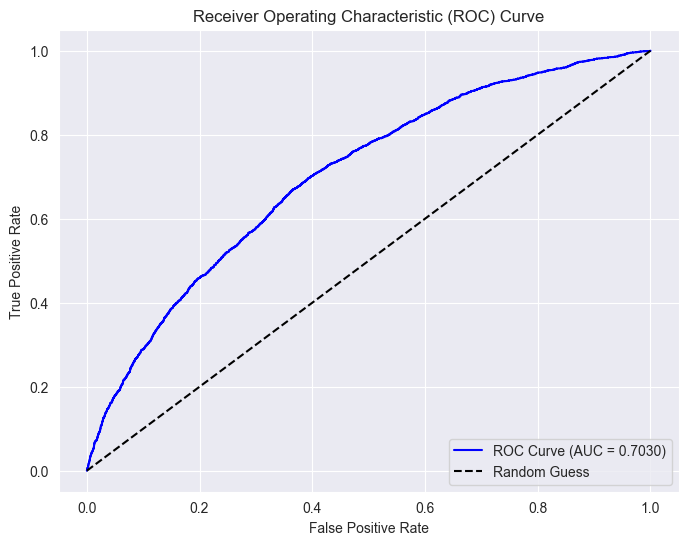

Stratified CV ROC-AUC Scores: [0.70307966 0.69951972 0.70086939 0.69883097 0.68673277]
Mean Stratified CV ROC-AUC: 0.6978


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_1, X_train, y_train, cv=cv, scoring="roc_auc")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Stratified CV ROC-AUC Scores: {cv_scores}")
print(f"Mean Stratified CV ROC-AUC: {np.mean(cv_scores):.4f}")


### Key Insights from the baseline model
1. Baseline model has a strtong recall 0.656. It is catching most defaulters, which is good for risk management
2. Precision is quite low, it is flagging too many good loans as bad. This may frustrate applicants or reduce profitability.
3. There's a 70.3 % chance the baselime model correctly ranks a defaulter above a non-defaulter.

In overall, the baseline model does a decent job spotting potential loan defaulters, correctly identifying about 70% of them overall. However, it still flags too many non-defaulters as risky, so it could benefit from further improvement such as hyperparameter tuning or model enhancement



